# Laboratorium 3

Celem trzeciego laboratorium jest zapoznanie się oraz zaimplementowanie algorytmów uczenia aktywnego. Zaimplementowane algorytmy będą testowane z wykorzystaniem wcześniej przygotowanych środowisk.


Dołączenie standardowych bibliotek

In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np

Dołączenie bibliotek ze środowiskami

In [2]:
from Pacman.qlearning import QLearningAgent
from env.dqnSimpleMDP import dqnSimpleMDP
from env.CliffWorldMDP import CliffWorld
# from QLearningAgent import QLearningAgent
from sarsa_agents import SARSAAgent, ExpectedSARSAAgent


## Zadanie 1 - SARSA($\lambda$)

<p style='text-align: justify;'>
Celem ćwiczenie jest zaimplementowanie algorytmu Q-Learning. Algorytm aktualizuje funkcję wartości stanu-akcji dla każdej odwiedzonej pary stan-akcja zgodnie ze wzorem:
\begin{equation}
    Q_{t + 1}(s, a) = Q_t(s, a) + \alpha \delta_t E_t(s, a)
\end{equation}
gdzie:
    
- $\delta_t = r_{t + 1} \gamma Q_t(s_{t + 1}, a_{t + 1}) - Q_t(s_{t}, a_{t})$,
    
- $E_t(s, a)$ - ślad dla pary stan - akcja w chwili czasowej $t$, zwiększany o $1$ w chwili odwiedzenia danego stanu.

</p>

In [3]:
import random
from collections import defaultdict


class SARSALambdaAgent:
    def __init__(self, alpha, epsilon, discount, get_legal_actions, lambda_value):
        """
        Q-Learning Agent
        based on https://inst.eecs.berkeley.edu/~cs188/sp19/projects.html
        Instance variables you have access to
          - self.epsilon (exploration prob)
          - self.alpha (learning rate)
          - self.discount (discount rate aka gamma)

        Functions you should use
          - self.get_legal_actions(state) {state, hashable -> list of actions, each is hashable}
            which returns legal actions for a state
          - self.get_qvalue(state,action)
            which returns Q(state,action)
          - self.set_qvalue(state,action,value)
            which sets Q(state,action) := value
        !!!Important!!!
        Note: please avoid using self._qValues directly.
            There's a special self.get_qvalue/set_qvalue for that.
        """

        self.get_legal_actions = get_legal_actions
        self._qvalues = defaultdict(lambda: defaultdict(lambda: 0))
        self._evalues = defaultdict(lambda: defaultdict(lambda: 0))
        self.alpha = alpha
        self.epsilon = epsilon
        self.discount = discount
        self.lambda_value = lambda_value
        # Add empty set for visited states
        self.visited_states = set()

    def get_qvalue(self, state, action):
        """ Returns Q(state,action) """
        return self._qvalues[state][action]

    def set_qvalue(self, state, action, value):
        """ Sets the Qvalue for [state,action] to the given value """
        self._qvalues[state][action] = value

    def reset(self):
        self._evalues = defaultdict(lambda: defaultdict(lambda: 0))
        self.visited_states = set()

    # ---------------------START OF YOUR CODE---------------------#

    def get_value(self, state):
        """
        Compute your agent's estimate of V(s) using current q-values
        V(s) = max_over_action Q(state,action) over possible actions.
        Note: please take into account that q-values can be negative.
        """
        possible_actions = self.get_legal_actions(state)

        # If there are no legal actions, return 0.0
        if len(possible_actions) == 0:
            return 0.0

        #
        # INSERT CODE HERE to get maximum possible value for a given state
        #
        
        values = []
        for i in len(possible_actions):
            values.append(self.get_qvalue(state, possible_actions[i]))

        return max(values)

    def update(self, state, action, reward, next_state):
        """
        You should do your SARSA-Lambda update here:
        """

        # agent parameters
        gamma = self.discount
        learning_rate = self.alpha

        #
        # INSERT CODE HERE to update value in the state for the action 
        #
        
        next_action = self.get_action(next_state)
        
        delta = reward + gamma * self.get_qvalue(next_state, next_action) - self.get_qvalue(state, action)
        self._evalues[state][action] += 1
        # dutch traces
        # self._evalues[state][action] = (1 - learning_rate) * gamma * self.lambda_value * self._evalues[state][action] + 1
        self.visited_states.add(state)
        
        for s in self.visited_states:
            for a in self.get_legal_actions(state):
                self.set_qvalue(s, a, self.get_qvalue(s, a) + learning_rate * delta * self._evalues[s][a])
                self._evalues[s][a] = gamma * self.lambda_value * self._evalues[s][a]
        

        return next_action

    def get_best_action(self, state):
        """
        Compute the best action to take in a state (using current q-values).
        """
        possible_actions = self.get_legal_actions(state)

        # If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None

        #
        # INSERT CODE HERE to get best action for a given state
        #
        #
        
        best_action_value = self.get_qvalue(state, possible_actions[0])
        best_actions = [possible_actions[0]]
        for action in possible_actions[1:]:
            value = self.get_qvalue(state, action)
            if value > best_action_value:
                best_actions = [action]
                best_action_value = value
            elif value == best_action_value:
                best_actions.append(action)

        best_action = random.choice(best_actions)

        return best_action

    def get_action(self, state):
        """
        Compute the action to take in the current state, including exploration.
        With probability self.epsilon, we should take a random action.
            otherwise - the best policy action (self.get_best_action).

        Note: To pick randomly from a list, use random.choice(list).
              To pick True or False with a given probablity, generate uniform number in [0, 1]
              and compare it with your probability
        """

        # Pick Action
        possible_actions = self.get_legal_actions(state)

        # If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None

        # agent parameters:
        epsilon = self.epsilon

        #
        # INSERT CODE HERE to get action in a given state (according to epsilon greedy algorithm)
        #        
        
        best_action = self.get_best_action(state)
        chosen_action = best_action

        if random.uniform(0, 1) < epsilon:
            random_actions = possible_actions.copy()
            random_actions.remove(best_action)
            chosen_action = random.choice(random_actions if random_actions else [best_action])

        return chosen_action

    def turn_off_learning(self):
        self.epsilon = 0
        self.alpha = 0

    def display_qvalues(self):
        for s in self._qvalues:
            print("State: " + str(s) + " " + str(self._qvalues[s]))


 Czas nauczyć agenta poruszania się po dowolnym środowisku:

In [3]:
def play_and_train(env, agent):
    """
    This function should
    - run a full game, actions given by agent's e-greedy policy
    - train agent using agent.update(...) whenever it is possible
    - return total reward
    """
    total_reward = 0.0
    state = env.reset()

    done = False

    agent.reset()
    action = agent.get_action(state)
    
    while not done:
        # get agent to pick action given state state.

        next_state, reward, done, _ = env.step(action)

        # train (update) agent for state
        action = agent.update(state, action, reward, next_state)

        state = next_state
        total_reward += reward
        if done:
            break
    return total_reward

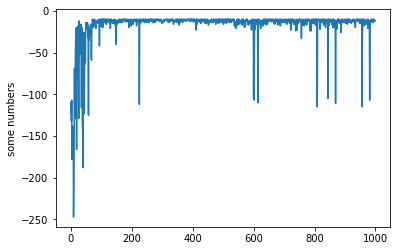

In [25]:
environment = CliffWorld()
agent = SARSALambdaAgent(alpha=0.1, epsilon=0.1, discount=0.99,
                   get_legal_actions=environment.get_possible_actions, lambda_value = 0.5)

rewards = []
for i in range(1000):
    rewards.append(play_and_train(environment, agent))

plt.plot(rewards)
plt.ylabel('some numbers')
plt.show()

## Zadanie 2 - Double Q-Learning

<p style='text-align: justify;'>
Celem ćwiczenie jest zaimplementowanie algorytmu Double Q-Learning. Algorytm aktualizuje funkcję wartości stanu-akcji zgodnie ze wzorami:
    \begin{equation*}
        Q_1(s_t, a_t) = Q_1(s_t, a_t) + \alpha[r_{t+1} + \gamma Q_2(argmax_a(Q_1(s_{t + 1}, a))) - Q_1(s_t, a_t)]
    \end{equation*}
    \begin{equation*}
        Q_2(s_t, a_t) = Q_2(s_t, a_t) + \alpha[r_{t+1} + \gamma Q_1(argmax_a(Q_2(s_{t + 1}, a))) - Q_2(s_t, a_t)]
    \end{equation*}
z prawdopodobieństwem wyboru każdej z opcji równym 50%.
</p>

In [4]:
import random
from collections import defaultdict


class DQLearningAgent:
    def __init__(self, alpha, epsilon, discount, get_legal_actions):
        """
        Q-Learning Agent
        based on https://inst.eecs.berkeley.edu/~cs188/sp19/projects.html
        Instance variables you have access to
          - self.epsilon (exploration prob)
          - self.alpha (learning rate)
          - self.discount (discount rate aka gamma)
        """

        self.get_legal_actions = get_legal_actions
        self._qvaluesA = defaultdict(lambda: defaultdict(lambda: 0))
        self._qvaluesB = defaultdict(lambda: defaultdict(lambda: 0))
        self.alpha = alpha
        self.epsilon = epsilon
        self.discount = discount


    #---------------------START OF YOUR CODE---------------------#
    
    def get_qvalueA(self, state, action):
        return self._qvaluesA[state][action]

    def set_qvalueA(self, state, action, value):
        self._qvaluesA[state][action] = value
        
    def get_qvalueB(self, state, action):
        return self._qvaluesB[state][action]

    def set_qvalueB(self, state, action, value):
        self._qvaluesB[state][action] = value
        
    def get_qvalue_sum(self, state, action):
        return self._qvaluesA[state][action] + self._qvaluesB[state][action]
    
    def get_qvalue(self, state, action):
        return  self.get_qvalue_sum(state, action)
        
    def get_value(self, state, which_list):
        if which_list == 'A':
            qvalues = self._qvaluesA
        elif which_list == 'B':
            qvalues = self._qvaluesB
        else:
            raise AttributeError('Choose A or B list!')
        
        possible_actions = self.get_legal_actions(state)

        # If there are no legal actions, return 0.0
        if len(possible_actions) == 0:
            return 0.0
        
        max_value = qvalues(state, possible_actions[0])
        for action in possible_actions[1:]:
            qvalue = qvalues(state, action)
            if qvalue > max_value:
                max_value = qvalue
        
        return max_value
        
    

    def update(self, state, action, reward, next_state):
        """
        You should do your Q-Value update here
        """

        # agent parameters
        gamma = self.discount
        learning_rate = self.alpha

        #
        # INSERT CODE HERE to update value in the state for the action 
        #
        
        
        
        if random.choice(['A', 'B']) == 'A':
            next_action = self.get_best_action(next_state, 'A')
            qvalue = self.get_qvalueA(state, action) + learning_rate * \
                     (reward + gamma * self.get_qvalueB(next_state, next_action) - self.get_qvalueA(state, action))
            self.set_qvalueA(state, action, qvalue)
        else:
            next_action = self.get_best_action(next_state, 'B')
            qvalue = self.get_qvalueB(state, action) + learning_rate * \
                     (reward + gamma * self.get_qvalueA(next_state, next_action) - self.get_qvalueB(state, action))
            self.set_qvalueB(state, action, qvalue)
            
        
        
    def get_best_action(self, state, which_q):
        if which_q == 'A':
            qvalue_func = self.get_qvalueA
        elif which_q == 'B':
            qvalue_func = self.get_qvalueB
        elif which_q == 'both':
            qvalue_func = self.get_qvalue_sum
        else:
            raise AttributeError("Choose A, B or both!")
            
        """
        Compute the best action to take in a state (using current q-values).
        """
        possible_actions = self.get_legal_actions(state)

        # If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None

        #
        # INSERT CODE HERE to get best possible action in a given state (remember to break ties randomly)
        #

        best_action_value = qvalue_func(state, possible_actions[0])
        best_actions = [possible_actions[0]]
        for action in possible_actions[1:]:
            value = qvalue_func(state, action)
            if value > best_action_value:
                best_actions = [action]
                best_action_value = value
            elif value == best_action_value:
                best_actions.append(action)

        best_action = random.choice(best_actions)

        return best_action


    def get_action_for_both_q(self, state):
        """
        Choose action with epsilon greedy policy for Q1 + Q2
        """

        # Pick Action
        possible_actions = self.get_legal_actions(state)

        # If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None

        # agent parameters:
        epsilon = self.epsilon

        best_action = self.get_best_action(state, 'both')
        chosen_action = best_action

        if random.uniform(0, 1) < epsilon:
            random_actions = possible_actions.copy()
            random_actions.remove(best_action)
            chosen_action = random.choice(random_actions if random_actions else [best_action])

        return chosen_action
    
    def get_action(self, state):
        return self.get_action_for_both_q(state)

    def turn_off_learning(self):
        self.epsilon = 0
        self.alpha = 0


In [5]:
env = dqnSimpleMDP()

max_tests = 10000
n_eps = 300
eps = 0.1
lr = 0.1

In [6]:
left_count_q = np.zeros(n_eps) #count left choices in state A for algorithm Q-Learning
left_count_dq = np.zeros(n_eps) #count left choices in state A for algorithm Double Q-Learning

q_estimate = np.zeros(n_eps) #store value estimation for choosing action left in left choices in state A for algorithm Q-Learning
dq_estimate = np.zeros(n_eps) #store value estimation for choosing action left in left choices in state A for algorithm Double Q-Learning

t = 0
s_1 = None
while t < max_tests:

    Q = {state: np.zeros(env.max_actions) for state in env.state_actions.keys()}
    agent = QLearningAgent(alpha=0.1, epsilon=0.1, discount=1,
                           get_legal_actions=env.get_possible_actions)
    for ep in range(n_eps):
        state = env.reset()
        while True:
            # Select eps-greedy action
            action = agent.get_action(state)

            # Count left actions from A
            if state == 'A' and action == 1:
                left_count_q[ep] += 1

            next_state, reward, done, _ = env.step(action)

            agent.update(state, action, reward, next_state)

            state = next_state
            if done:
                q_estimate[ep] += agent.get_qvalue('A', 1)

                break
    t += 1

q_estimate /= max_tests

In [7]:
t = 0
while t < max_tests:

    agent = DQLearningAgent(alpha=0.1, epsilon=0.1, discount=1,
                            get_legal_actions=env.get_possible_actions)
    for ep in range(n_eps):
        state = env.reset()
        while True:
            # Select eps-greedy action
            action = agent.get_action(state)

            # Count left actions from A
            if state == 'A' and action == 1:
                left_count_dq[ep] += 1

            next_state, reward, done, _ = env.step(action)

            agent.update(state, action, reward, next_state)

            state = next_state
            if done:
                dq_estimate[ep] += agent.get_qvalue('A', 1) / 2

                break
    t += 1

dq_estimate /= max_tests

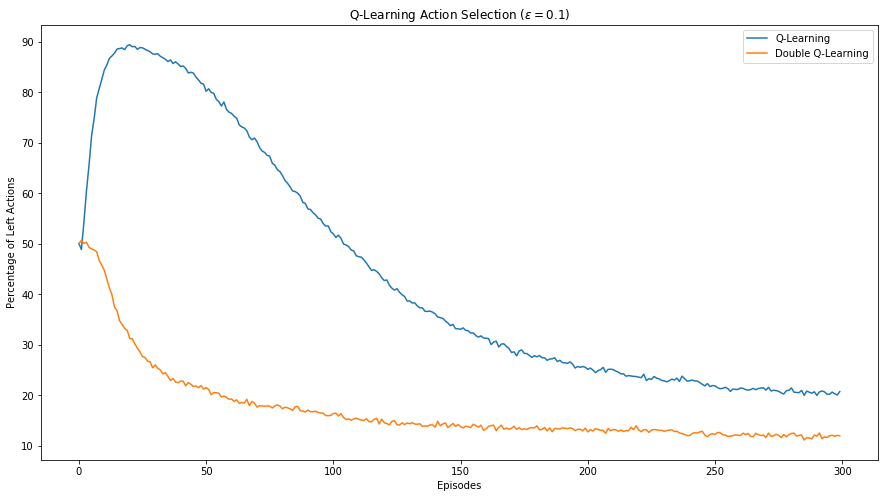

In [8]:
plt.figure(figsize=(15,8))
plt.plot(left_count_q/max_tests*100,
         label='Q-Learning')
plt.plot(left_count_dq/max_tests*100,
         label='Double Q-Learning')
plt.ylabel('Percentage of Left Actions')
plt.xlabel('Episodes')
plt.title(r'Q-Learning Action Selection ($\epsilon=0.1$)')
plt.legend(loc='best')
plt.show()




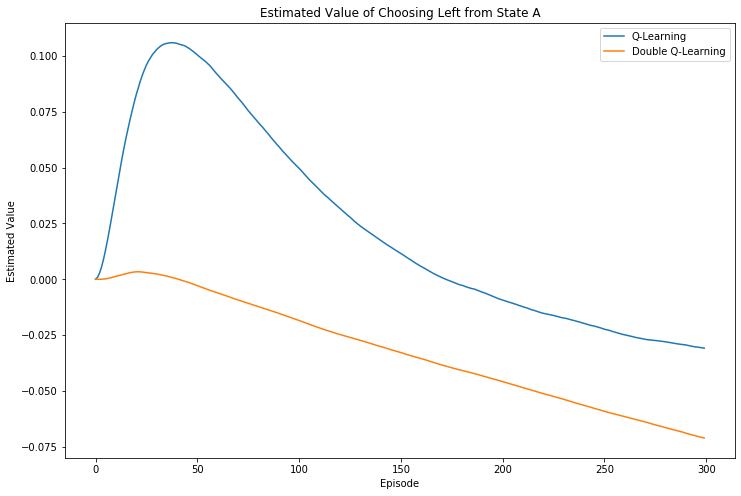

In [9]:
plt.figure(figsize=(12,8))
plt.plot(q_estimate, label='Q-Learning')
plt.plot(dq_estimate, label='Double Q-Learning')

plt.legend()
plt.xlabel('Episode')
plt.ylabel('Estimated Value')
plt.title('Estimated Value of Choosing Left from State A')
plt.show()

## Zadanie 3 

Przetestuj działanie wszystkich zaimplementowanych algorytmów w środowisku dqnSimpleMDP, który algorytm działa najlepiej?

In [10]:
left_count_sarsa = np.zeros(n_eps) 
left_count_expected_sarsa = np.zeros(n_eps)
left_count_lambda_sarsa = np.zeros(n_eps)

sarsa_estimate = np.zeros(n_eps)
expected_sarsa_estimate = np.zeros(n_eps)
lambda_sarsa_estimate = np.zeros(n_eps)


In [11]:
# Sarsa
t = 0
while t < max_tests:

    Q = {state: np.zeros(env.max_actions) for state in env.state_actions.keys()}
    agent = SARSAAgent(alpha=0.1, epsilon=0.1, discount=0.99,
                   get_legal_actions=env.get_possible_actions)
    for ep in range(n_eps):
        state = env.reset()
        while True:
            # Select eps-greedy action
            action = agent.get_action(state)

            # Count left actions from A
            if state == 'A' and action == 1:
                left_count_sarsa[ep] += 1

            next_state, reward, done, _ = env.step(action)

            agent.update(state, action, reward, next_state)

            state = next_state
            if done:
                sarsa_estimate[ep] += agent.get_qvalue('A', 1)

                break
    t += 1

sarsa_estimate /= max_tests

In [12]:
# Expected Sarsa
t = 0
while t < max_tests:

    Q = {state: np.zeros(env.max_actions) for state in env.state_actions.keys()}
    agent = ExpectedSARSAAgent(alpha=0.1, epsilon=0.1, discount=0.99,
                       get_legal_actions=env.get_possible_actions)
    for ep in range(n_eps):
        state = env.reset()
        while True:
            # Select eps-greedy action
            action = agent.get_action(state)

            # Count left actions from A
            if state == 'A' and action == 1:
                left_count_expected_sarsa[ep] += 1

            next_state, reward, done, _ = env.step(action)

            agent.update(state, action, reward, next_state)

            state = next_state
            if done:
                expected_sarsa_estimate[ep] += agent.get_qvalue('A', 1)
                break
    t += 1

expected_sarsa_estimate /= max_tests

In [13]:
# Sarsa Lambda
t = 0
while t < max_tests:

    Q = {state: np.zeros(env.max_actions) for state in env.state_actions.keys()}
    agent = SARSALambdaAgent(alpha=0.1, epsilon=0.1, discount=0.99,
                   get_legal_actions=env.get_possible_actions, lambda_value = 0.5)
    for ep in range(n_eps):
        state = env.reset()
        while True:
            # Select eps-greedy action
            action = agent.get_action(state)

            # Count left actions from A
            if state == 'A' and action == 1:
                left_count_lambda_sarsa[ep] += 1

            next_state, reward, done, _ = env.step(action)

            agent.update(state, action, reward, next_state)

            state = next_state
            if done:
                lambda_sarsa_estimate[ep] += agent.get_qvalue('A', 1)
                break
    t += 1

lambda_sarsa_estimate /= max_tests

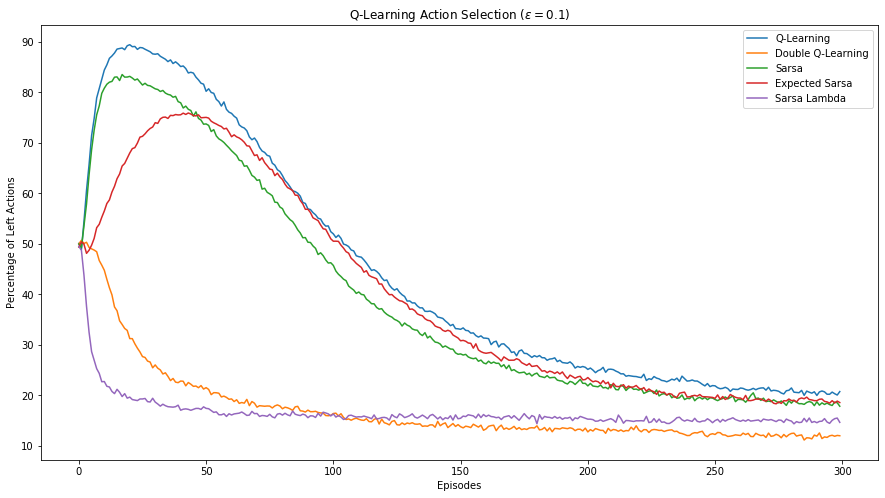

In [14]:
plt.figure(figsize=(15,8))
plt.plot(left_count_q/max_tests*100,
         label='Q-Learning')
plt.plot(left_count_dq/max_tests*100,
         label='Double Q-Learning')
plt.plot(left_count_sarsa/max_tests*100,
         label='Sarsa')
plt.plot(left_count_expected_sarsa/max_tests*100,
         label='Expected Sarsa')
plt.plot(left_count_lambda_sarsa/max_tests*100,
         label='Sarsa Lambda')
plt.ylabel('Percentage of Left Actions')
plt.xlabel('Episodes')
plt.title(r'Q-Learning Action Selection ($\epsilon=0.1$)')
plt.legend(loc='best')
plt.show()

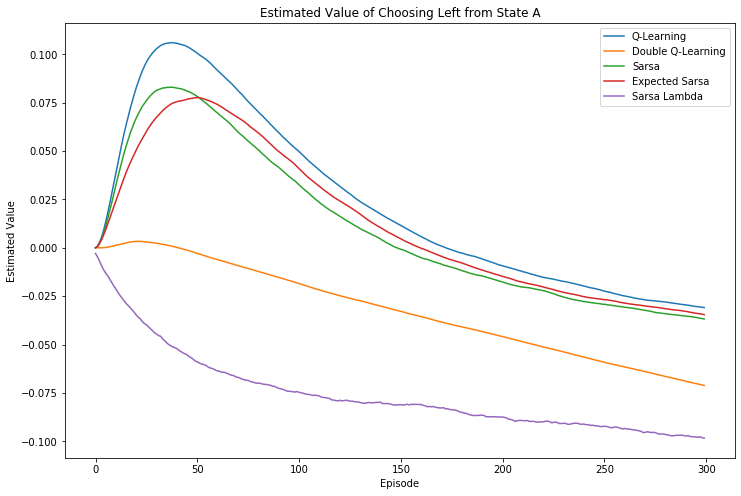

In [16]:
plt.figure(figsize=(12,8))
plt.plot(q_estimate, label='Q-Learning')
plt.plot(dq_estimate, label='Double Q-Learning')
plt.plot(sarsa_estimate, label='Sarsa')
plt.plot(expected_sarsa_estimate, label='Expected Sarsa')
plt.plot(lambda_sarsa_estimate, label='Sarsa Lambda')

plt.legend()
plt.xlabel('Episode')
plt.ylabel('Estimated Value')
plt.title('Estimated Value of Choosing Left from State A')
plt.show()